In [1]:
#coding:utf-8
import time
import pandas as pd
import os
import csv
import datetime
from sqlalchemy import create_engine
import numpy as np
import pymysql
from WindPy import *
import copy

In [2]:
w.start()
a=w.wsi("NI1701.SHF", "pct_chg,oi,open,volume,close", "2013-01-01 00:00:00", "2016-10-20 23:59:59", "")
data=pd.DataFrame()
data['time']=a.Times
for i in range(len(a.Fields)):

    data[a.Fields[i]]=a.Data[i]
w.stop()
data['time']=pd.to_datetime(data['time'])

data['Date']=data['time'].apply(lambda x:str(x.date()) if x.hour<=17 else np.nan)
data=data.sort(['time'])
data['Date']=data['Date'].fillna(method='bfill')
data['Date']=pd.to_datetime(data['Date'])
data=data.dropna(subset=['Date','position','open','volume','close'])

Welcome to use Wind Quant API for Python (WindPy)!
You can use w.menu to help yourself to create commands(WSD,WSS,WST,WSI,WSQ,...)!

COPYRIGHT (C) 2016 WIND HONGHUI INFORMATION & TECHKNOLEWDGE CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [3]:


P=np.abs(data['pctchange'])/np.sqrt(data['volume'])
P_data=copy.deepcopy(data)
P_data['P']=P

P_data_sorted=P_data.sort(['P'],ascending=False)

P_amt_daily=P_data_sorted['volume'].sum()



P_total=pd.DataFrame()
for i, j in P_data_sorted.groupby('Date'):
    sum_vol=0
    all_vol=j['volume'].sum()
    target_vol=0.1*all_vol
    k=0
    while sum_vol<target_vol:
        
        sum_vol+=j.iloc[k,:]['volume']
        k+=1
    j_selected=j.iloc[:k,:]
    P_total=P_total.append(j_selected)

P_star=P_total.groupby("Date").pctchange.sum()
P_star=pd.DataFrame(P_star)
P_star=P_star.rename(columns={'pctchange':'P'})

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [4]:
Q=np.abs(np.diff(data['position']))/np.sqrt(data['volume'])[1:]
Q_data=copy.deepcopy(data)
Q_data['Q']=Q

Q_data_sorted=Q_data.sort(['Q'],ascending=False)

Q_amt_daily=Q_data_sorted['volume'].sum()



Q_total=pd.DataFrame()
for i, j in Q_data_sorted.groupby('Date'):
    sum_vol=0
    all_vol=j['volume'].sum()
    target_vol=0.1*all_vol
    k=0
    while sum_vol<target_vol:
        
        sum_vol+=j.iloc[k,:]['volume']
        k+=1
    j_selected=j.iloc[:k,:]
    Q_total=Q_total.append(j_selected)

Q_star=Q_total.groupby("Date").pctchange.sum()
Q_star=pd.DataFrame(Q_star)
Q_star=Q_star.rename(columns={'pctchange':'Q'})

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [16]:
Indicator_total=pd.concat([P_star,Q_star],axis=1)

In [17]:
Indicator_total['P_MA4']=pd.rolling_mean(Indicator_total['P'],4)
Indicator_total['Q_MA5']=pd.rolling_mean(Indicator_total['Q'],5)

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).mean()
  if __name__ == '__main__':
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
  from ipykernel import kernelapp as app


In [18]:
Indicator_total['P_star']=Indicator_total['P']-Indicator_total['P_MA4']
Indicator_total['Q_star']=Indicator_total['Q']-Indicator_total['Q_MA5']

In [19]:
Indicator_total['Prod']=Indicator_total['P_star']*Indicator_total['Q_star']

In [20]:
Indicator_total=Indicator_total.dropna(subset=['Prod'])

In [21]:
Indicator_total['Decision']=Indicator_total['Prod'].apply(lambda x: 1 if x>0 else -1)

In [22]:
Indicator_total=Indicator_total.reset_index()

In [24]:
Indicator_total['Date']=Indicator_total['Date']+np.timedelta64(1,'D')

In [26]:
Indicator_total.index=[Indicator_total['Date']]
Indicator_total=Indicator_total.drop('Date',axis=1)

In [226]:
#回测计算

In [27]:
daily_price=[]
return_data=copy.deepcopy(data)
for i,j in return_data.groupby('Date'):
    j=j.sort(['time'])
    j_1=j.head(5)
    p=np.dot(j_1['close'],j_1['volume'].T)/np.sum(j_1['volume'])
    temp=[i,p]
    daily_price.append(temp)
daily_P=pd.DataFrame(daily_price)


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [28]:
daily_P=daily_P.rename(columns={0:'Date',1:'Price'})

In [29]:
daily_P['Return']=np.nan
daily_P['Return'][1:]=np.diff(np.log(daily_P['Price']))

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [30]:
daily_P.index=[daily_P['Date']]

In [31]:
daily_P=daily_P.drop('Date',axis=1)

In [32]:
result=pd.concat([daily_P,Indicator_total],join='inner',axis=1)

In [33]:
result['Final_Return']=result['Return']*result['Decision']

In [35]:
lin=result['Final_Return'].dropna()

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

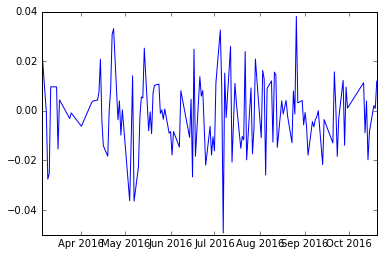

In [37]:
plt.plot(lin)

In [38]:
np.sum(lin)

-0.16679095984482473

In [39]:
result=result.reset_index()

In [40]:
result_2=result[result['Date']>=pd.to_datetime('2016-05-01')]
result_2.index=[result_2['Date']]

In [41]:
result_2['Final_Return'].sum()

-0.20281470916214595

In [42]:
lin=result_2['Final_Return'].dropna()

<Container object of 110 artists>

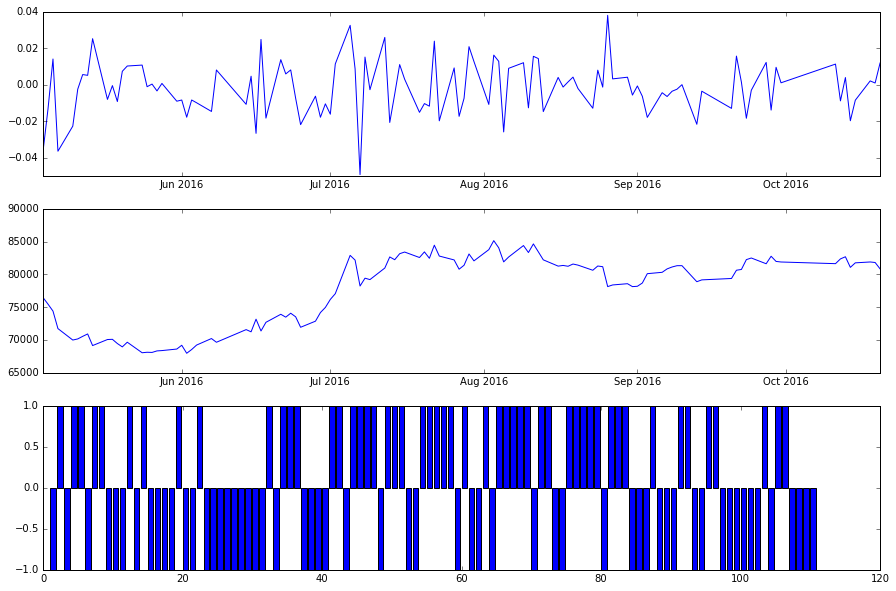

In [43]:
plt.figure(figsize=(15,10))
fig=plt.subplot(3,1,1)
plt.plot(result_2['Final_Return'])
fig=plt.subplot(3,1,2)
plt.plot(result_2['Price'])
fig=plt.subplot(3,1,3)
plt.bar(np.arange(len(result_2))+1,result_2['Decision'])

In [44]:
np.sum(result_2['Final_Return'])

-0.20281470916214595

In [46]:
result_2['accu_rate']=result_2['Return']*result_2['Decision']

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [48]:
result_2['accu_rate']=result_2['accu_rate'].apply(lambda x:1 if x>0 else 0)

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [49]:
np.float(np.sum(result_2['accu_rate']))/len(result_2)

0.45454545454545453